In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score ,precision_score,f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Score Classifier 

I added the precision score to minimize false positives, i.e. falsely classifying a player as a good (positive) prospect is costly for the investors. Since we are building a model to predict which NBA players are likely to have a longevity of more than 5 years, we might want to minimize the number of "false alarms" by only selecting the most promising players.

I will keep the recall of course to minimize false negatives. Because we do not want to miss out on future promising NBA talents, this metric is important.

In order to find the best compromise between precision and recall we will use F1 score which is a harmonic average of the two

In [2]:

def score_classifier(dataset,classifier,labels):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = KFold(n_splits=3,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recall = 0
    precision=0
    
    for training_ids,test_ids in kf.split(dataset):
        
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
        precision+=precision_score(test_labels, predicted_labels)
        f1=f1_score(test_labels, predicted_labels)

    recall/=3
    precision /=3
    f1/=3

    return(precision,recall,f1,confusion_mat,classifier) 
    



In [5]:
df = pd.read_csv("nba_logreg.csv")


In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values[missing_values > 0]) 

Missing Values:
3P%    11
dtype: int64


In [8]:
# NAN in 3P% means the players didn't score any 3 points attemps , so we replace the missing values with 0
df = pd.read_csv("nba_logreg.csv")
df=df.fillna(0.0)

In [3]:
names = df['Name'].values.tolist() 
labels = df['TARGET_5Yrs'].values 

## DATA ANALYSIS

Considering the variable Target_5_years , we will begin by a data analysis with a correlation plot to know what variables might be interesting to predict the five years longevity 

In [111]:
import seaborn as sns

In [4]:
df

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,Chris Smith,80,15.8,4.3,1.6,3.6,43.3,0.0,0.2,14.3,...,1.5,79.2,0.4,0.8,1.2,2.5,0.6,0.2,0.8,0.0
1336,Brent Price,68,12.6,3.9,1.5,4.1,35.8,0.1,0.7,16.7,...,1.0,79.4,0.4,1.1,1.5,2.3,0.8,0.0,1.3,1.0
1337,Marlon Maxey,43,12.1,5.4,2.2,3.9,55.0,0.0,0.0,0.0,...,1.6,64.3,1.5,2.3,3.8,0.3,0.3,0.4,0.9,0.0
1338,Litterial Green,52,12.0,4.5,1.7,3.8,43.9,0.0,0.2,10.0,...,1.8,62.5,0.2,0.4,0.7,2.2,0.4,0.1,0.8,1.0


In [113]:
correlation_matrix = df.corr()

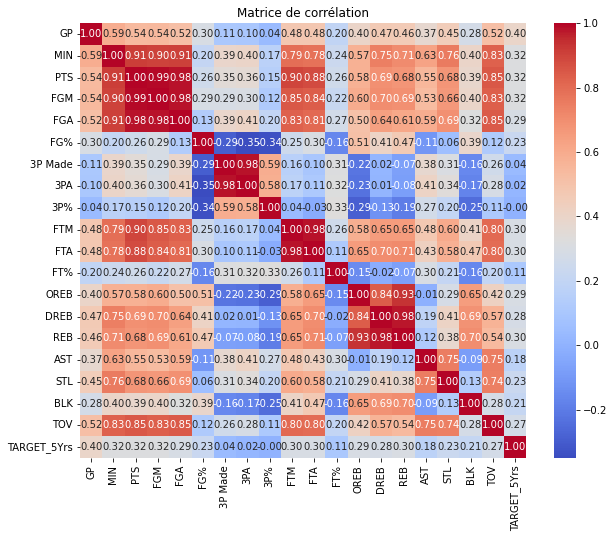

In [114]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

There aren't many strong insights we can take away from the correlation plot but we can notice that GP (Games played) is the most important feature with predicting career longevity, this makes sense because a player's development is enhanced with more playing time. And we can notice also , that 3P Made,3PA and 3P% are les important than other features to predict the player's longevity. 






# Models

I will use classification methods such as Logistic Regression ,Linear and Quadratic Discriminant Analysis (LDA & QDA ) and a MLP since our target (five years) is a categorical variable.

Of course there are plenty of other methods to deal with a binary classification like KNNs , Random forests , XGBoost ... but I prefered using LDA & QDA instead because I assume that the relationship between the Input features (stats) and target variable (5year longevity) is approximatively linear or quadratic ( not highly non linear).

## Logistic Regression 

Based on the correlation matrix I will make 4 models with 4 combinations of features ; the first combination I will let all the features ; the second I will delete all the features with a correlation score lower than 0,11 ; the third I will delete all the features with a correlation score lower than 0,21; and finally with a correlation score lower than 0,3

In [115]:
from sklearn.linear_model import LogisticRegression

In [116]:
features_list= [
    ['GP', 'MIN', 'PTS', 'FGM','FGA','FG%','3P Made','3PA','3P%','FTM','FTA','FT%','OREB','DREB','REB','AST','STL','BLK','TOV'],
    ['GP', 'MIN', 'PTS', 'FGM','FGA','FG%','FTM','FTA','FT%','OREB','DREB','REB','AST','STL','BLK','TOV'],
    ['GP', 'MIN', 'PTS', 'FGM','FGA','FG%','FTM','FTA','OREB','DREB','REB','STL','BLK','TOV'],
    ['GP', 'MIN', 'PTS', 'FGM','FTM','FTA','REB'],
   
]
model_names = [
    'LR_1',
    'LR_2',
    'LR_3',
    'LR_4',
   
]

In [117]:
results_LR= pd.DataFrame(columns=['model_name', 'precision', 'recall', 'f1','confusion'])
trained_models_LR=[]
for i,features in enumerate(features_list) :

    model_name=model_names[i]
    data= df[features].values
    X = MinMaxScaler().fit_transform(data)
    model=LogisticRegression()
    precision,recall,f1,confusion_mat,trained_model= score_classifier(X,model,labels)
    trained_models_LR.append(trained_model)

    results_LR= results_LR.append({'model_name': model_name, 'precision': precision, 'recall': recall,'f1': f1, 'confusion': confusion_mat}, ignore_index=True)

print(results_LR)

  model_name  precision    recall        f1                         confusion
0       LR_1   0.738948  0.826680  0.265546  [[266.0, 243.0], [144.0, 687.0]]
1       LR_2   0.738521  0.831494  0.265773  [[264.0, 245.0], [140.0, 691.0]]
2       LR_3   0.733048  0.821842  0.263305  [[260.0, 249.0], [148.0, 683.0]]
3       LR_4   0.739546  0.819369  0.265087  [[269.0, 240.0], [150.0, 681.0]]


The highest f1 score corresponds to the best compromise between the precision and recall , it is by removing the 3 features (3P made,3PA,3P%) according to the lowest correlations coefficient (near 0) , so the second model has the best performance here 

## LDA

I will keep the same feature combinations I used in Logistic Regression since I got accurate results 

In [118]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [119]:
features_list= [
    ['GP', 'MIN', 'PTS', 'FGM','FGA','FG%','3P Made','3PA','3P%','FTM','FTA','FT%','OREB','DREB','REB','AST','STL','BLK','TOV'],
    ['GP', 'MIN', 'PTS', 'FGM','FGA','FG%','FTM','FTA','FT%','OREB','DREB','REB','AST','STL','BLK','TOV'],
    ['GP', 'MIN', 'PTS', 'FGM','FGA','FG%','FTM','FTA','OREB','DREB','REB','STL','BLK','TOV'],
    ['GP', 'MIN', 'PTS', 'FGM','FTM','FTA','REB'],
   
]
model_names = [
    'LDA_1',
    'LDA_2',
    'LDA_3',
    'LDA_4',  
]

In [120]:
df = pd.read_csv("nba_logreg.csv")
df=df.fillna(0.0)
names = df['Name'].values.tolist() 
labels = df['TARGET_5Yrs'].values 

In [121]:
results_LDA= pd.DataFrame(columns=['model_name', 'precision', 'recall', 'f1','confusion'])
trained_models_LDA=[]

for i,features in enumerate(features_list) :

    model_name=model_names[i]
    data= df[features].values
    X = MinMaxScaler().fit_transform(data)

    model=LinearDiscriminantAnalysis()
    precision,recall,f1,confusion_mat,trained_model= score_classifier(X,model,labels)
    trained_models_LDA.append(trained_model)

    results_LDA = results_LDA.append({'model_name': model_name, 'precision': precision, 'recall': recall,'f1': f1, 'confusion': confusion_mat}, ignore_index=True)

print(results_LDA)

  model_name  precision    recall        f1                         confusion
0      LDA_1   0.727798  0.825391  0.266004  [[252.0, 257.0], [145.0, 686.0]]
1      LDA_2   0.739007  0.830249  0.267778  [[265.0, 244.0], [141.0, 690.0]]
2      LDA_3   0.736433  0.819459  0.264426  [[265.0, 244.0], [150.0, 681.0]]
3      LDA_4   0.738516  0.810988  0.264387  [[270.0, 239.0], [157.0, 674.0]]


Same as the Logistic Regression the second model has the best performance if we take into consideration both the recall and precision

## QDA

Same here we let the same features combination list

In [122]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


In [123]:
features_list= [
    ['GP', 'MIN', 'PTS', 'FGM','FGA','FG%','3P Made','3PA','3P%','FTM','FTA','FT%','OREB','DREB','REB','AST','STL','BLK','TOV'],
    ['GP', 'MIN', 'PTS', 'FGM','FGA','FG%','FTM','FTA','FT%','OREB','DREB','REB','AST','STL','BLK','TOV'],
    ['GP', 'MIN', 'PTS', 'FGM','FGA','FG%','FTM','FTA','OREB','DREB','REB','STL','BLK','TOV'],
    ['GP', 'MIN', 'PTS', 'FGM','FTM','FTA','REB'],
   
]
model_names = [
    'QDA_1',
    'QDA_2',
    'QDA_3',
    'QDA_4',  
]

In [124]:
results_QDA= pd.DataFrame(columns=['model_name', 'precision', 'recall', 'f1','confusion'])
trained_models_QDA=[]
for i,features in enumerate(features_list) :

    model_name=model_names[i]
    data= df[features].values
    X = MinMaxScaler().fit_transform(data)

    model=QuadraticDiscriminantAnalysis()
    precision,recall,f1,confusion_mat,trained_model= score_classifier(X,model,labels)
    trained_models_QDA.append(trained_model)

    results_QDA = results_QDA.append({'model_name': model_name, 'precision': precision, 'recall': recall,'f1': f1, 'confusion': confusion_mat}, ignore_index=True)

print(results_QDA)

  model_name  precision    recall        f1                         confusion
0      QDA_1   0.791349  0.582380  0.225017  [[381.0, 128.0], [347.0, 484.0]]
1      QDA_2   0.798072  0.569337  0.218440  [[389.0, 120.0], [358.0, 473.0]]
2      QDA_3   0.797820  0.569293  0.218003  [[389.0, 120.0], [358.0, 473.0]]
3      QDA_4   0.801128  0.603041  0.230504  [[383.0, 126.0], [330.0, 501.0]]


QDA has by far the best precision but the lowest recall ,  so the models are performing poorly in terms of correctly identifying true positive cases.

## MLP 

For MLP I will add another features combinations having correlation score higher than 0,32

In [125]:
from sklearn.neural_network import MLPClassifier


In [126]:
features_list= [
    ['GP', 'MIN', 'PTS', 'FGM','FGA','FG%','3P Made','3PA','3P%','FTM','FTA','FT%','OREB','DREB','REB','AST','STL','BLK','TOV'],
    ['GP', 'MIN', 'PTS', 'FGM','FGA','FG%','FTM','FTA','FT%','OREB','DREB','REB','AST','STL','BLK','TOV'],
    ['GP', 'MIN', 'PTS', 'FGM','FGA','FG%','FTM','FTA','OREB','DREB','REB','STL','BLK','TOV'],
    ['GP', 'MIN', 'PTS', 'FGM','FTM','FTA','REB'],
    ['GP', 'MIN', 'PTS', 'FGM','FGA','FTM','FTA','OREB','DREB','REB']
   
]
model_names = [
    'MLP_1',
    'MLP_2',
    'MLP_3',
    'MLP_4', 
    'MLP_5'
]

In [127]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
results_mlp= pd.DataFrame(columns=['model_name', 'precision', 'recall', 'f1','confusion'])
trained_models_MLP=[]

for i,features in enumerate(features_list) :

    model_name=model_names[i]
    data= df[features].values
    X = MinMaxScaler().fit_transform(data)

    model=mlp
    precision,recall,f1,confusion_mat,trained_model= score_classifier(X,model,labels)
    trained_models_MLP.append(trained_model)
   

    results_mlp= results_mlp.append({'model_name': model_name, 'precision': precision, 'recall': recall,'f1': f1, 'confusion': confusion_mat}, ignore_index=True)

print(results_mlp)

  model_name  precision    recall        f1                         confusion
0      MLP_1   0.721263  0.733472  0.240000  [[271.0, 238.0], [222.0, 609.0]]
1      MLP_2   0.729291  0.792764  0.262895  [[265.0, 244.0], [172.0, 659.0]]
2      MLP_3   0.725145  0.813112  0.262493  [[253.0, 256.0], [155.0, 676.0]]
3      MLP_4   0.741520  0.803852  0.260470  [[276.0, 233.0], [163.0, 668.0]]
4      MLP_5   0.755334  0.771527  0.253571  [[301.0, 208.0], [190.0, 641.0]]


The third model is  the best by achieving a perfect compromise between our two metrics

## Assessment 

I sort the performance of my models according to the models having the best precision, the best recall and the best compromise between the 2

In [128]:
results=pd.concat([results_LR,results_LDA, results_QDA, results_mlp])
sorted_results = results.sort_values(by='recall',ascending=False)
top_results = sorted_results.head(8)
print(top_results.to_markdown(index=False))




| model_name   |   precision |   recall |       f1 | confusion     |
|:-------------|------------:|---------:|---------:|:--------------|
| LR_2         |    0.738521 | 0.831494 | 0.265773 | [[264. 245.]  |
|              |             |          |          |  [140. 691.]] |
| LDA_2        |    0.739007 | 0.830249 | 0.267778 | [[265. 244.]  |
|              |             |          |          |  [141. 690.]] |
| LR_1         |    0.738948 | 0.82668  | 0.265546 | [[266. 243.]  |
|              |             |          |          |  [144. 687.]] |
| LDA_1        |    0.727798 | 0.825391 | 0.266004 | [[252. 257.]  |
|              |             |          |          |  [145. 686.]] |
| LR_3         |    0.733048 | 0.821842 | 0.263305 | [[260. 249.]  |
|              |             |          |          |  [148. 683.]] |
| LDA_3        |    0.736433 | 0.819459 | 0.264426 | [[265. 244.]  |
|              |             |          |          |  [150. 681.]] |
| LR_4         |    0.739546 | 0.8

LR_2 is the model with the best recall ,

[[264. 245.]  
[140. 691.]]

as we can see from the confusion matrix of the model, the model misses only 140 positive talents by classifying them as negative prospects , but classifies 245 false positives which can be costly for the investors who will invest on false alarms 

In [129]:
results=pd.concat([results_LR,results_LDA, results_QDA, results_mlp])
sorted_results = results.sort_values(by='precision',ascending=False)
top_results = sorted_results.head(8)
print(top_results.to_markdown(index=False))

| model_name   |   precision |   recall |       f1 | confusion     |
|:-------------|------------:|---------:|---------:|:--------------|
| QDA_4        |    0.801128 | 0.603041 | 0.230504 | [[383. 126.]  |
|              |             |          |          |  [330. 501.]] |
| QDA_2        |    0.798072 | 0.569337 | 0.21844  | [[389. 120.]  |
|              |             |          |          |  [358. 473.]] |
| QDA_3        |    0.79782  | 0.569293 | 0.218003 | [[389. 120.]  |
|              |             |          |          |  [358. 473.]] |
| QDA_1        |    0.791349 | 0.58238  | 0.225017 | [[381. 128.]  |
|              |             |          |          |  [347. 484.]] |
| MLP_5        |    0.755334 | 0.771527 | 0.253571 | [[301. 208.]  |
|              |             |          |          |  [190. 641.]] |
| MLP_4        |    0.74152  | 0.803852 | 0.26047  | [[276. 233.]  |
|              |             |          |          |  [163. 668.]] |
| LR_4         |    0.739546 | 0.8

QDA_4 with the best precision but with really bad recall ,


[[383. 126.]  
 [330. 501.]]
 
 as we can notice from the confusion matrix , QDA_4 has a higher precision than the previous model , only 126 False alarms but still 330 missed promising and positive prospects.

In [130]:
results=pd.concat([results_LR,results_LDA, results_QDA, results_mlp])
sorted_results = results.sort_values(by=['f1'],ascending=False)
top_results = sorted_results.head(8)
print(top_results.to_markdown(index=False))

| model_name   |   precision |   recall |       f1 | confusion     |
|:-------------|------------:|---------:|---------:|:--------------|
| LDA_2        |    0.739007 | 0.830249 | 0.267778 | [[265. 244.]  |
|              |             |          |          |  [141. 690.]] |
| LDA_1        |    0.727798 | 0.825391 | 0.266004 | [[252. 257.]  |
|              |             |          |          |  [145. 686.]] |
| LR_2         |    0.738521 | 0.831494 | 0.265773 | [[264. 245.]  |
|              |             |          |          |  [140. 691.]] |
| LR_1         |    0.738948 | 0.82668  | 0.265546 | [[266. 243.]  |
|              |             |          |          |  [144. 687.]] |
| LR_4         |    0.739546 | 0.819369 | 0.265087 | [[269. 240.]  |
|              |             |          |          |  [150. 681.]] |
| LDA_3        |    0.736433 | 0.819459 | 0.264426 | [[265. 244.]  |
|              |             |          |          |  [150. 681.]] |
| LDA_4        |    0.738516 | 0.8

So for the best compromise between the recall and precision , the best model is LDA 2 obtained by removing 3 features (3P made,3PA,3P%), So I will rely on this model to build the API 

It is true that the best model in term of less features inputs is LDA_4 which uses only 7 inputs (['GP', 'MIN', 'PTS', 'FGM','FGA','FTM','FTA','OREB','DREB','REB']) which makes it easier for the investors , but our goal in our project is to have the model with the best perfomance that's why I will use LDA_2 with 16 inputs

# SAVING THE BEST MODEL

In [131]:
model=trained_models_LDA[1]

In [132]:
import pickle

with open('modele_lda.pkl', 'wb') as file:
    pickle.dump(model, file)